# Using RADICAL-Analytics With RADICAL-Pilot and OSG Experiments

This notebook illustrates the analysis of two experiments performed with RADICAL-Pilot and OSG. The experiments use 4 1-core pilots and between 8 and 64 compute units (CU). RADICAL-Anlytics is used to acquire two data sets produced by RADICAL Pilot and then to derive aggregated and per-entity performance measures. 

The state models of RADICAL-Pilot's CU and Pilot entities is presented and all the state-based durations are defined and described. Among these durations, both aggregated and per-entity measures are computed and plotted. The aggreageted measures are:

* **TTC**: Total time to completion of the given workload, i.e., between 8 and 64 CU; 
* **TTQ**: Total time spent by the 4 1-core pilots in the OSG Connect queue;
* **TTR**: Total time spent by the four pilots running on their respective work node;
* **TTX**: Total time spent by all the CU executing their kernel.

Each aggregate measure takes into account the time overlap among entities in the same state. For example, if a pilot start running at time t_0, another at time t_0+5s and they both finish at time t_0+100s, TTR will be 100s, not 195s. The same calculation is done for partial, total, and null overlapping.

Single-entity performance measures are derived for each pilot and CU:

* **Tq**: Time spent by a pilot in the queue of the local resource management system (LRMS);
* **Tx**: Time spent by a CU executing its kernel.

The kernel of each CU is a <a href='https://github.com/radical-cybertools/radical.synapse'>Synapse</a> executable emulating a GROMACS execution as specified in the <a href='https://docs.google.com/document/d/1TQrax9iSGovECZZ7wyomVk_LbFjNqeRNCUtEkv7FXfg/edit'>GROMACS/CoCo ENSEMBLES</a> use case. 

We plot and compare these measurements across the two experiments to understand: 

* **How the heterogeneity of OSG resources affects the execution of this type of workload.**
* **Whether queuing time is as dominant as in XSEDE.**

# Setup

We need to setup both this notebook and the experiment environment. We start with the notebook and then we will move on to the experiment data. 

## Notebook Settings

Display matplotlib diagrams without having to use `plt.show()`.

In [1]:
%matplotlib inline

Load all the Python modules we will use for the analysis. Note that both RADICAL Utils and RADICAL Pilot need to be loaded alongside RADICAL Analytics.

In [2]:
import os
import sys
import glob
import pprint

import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.display import display

/Users/mturilli/Virtualenvs/RADICAL-ANALYTICS/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:58: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


We configure matplotlib so to produce visually consistent diagrams that look readable and we can directly include in a paper written in LaTeX.

In [3]:
# Global configurations
# ---------------------

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75

# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue   [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green  [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red    [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown  [10,11]
             (227, 119, 194), (247, 182, 210), # pink   [12,13]
             (127, 127, 127), (199, 199, 199), # gray   [14,15]
             (188, 189, 34 ), (219, 219, 141), # yellow [16,17]
             (23 , 190, 207), (158, 218, 229)] # cyan   [18,19]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return ax

## Experiment Settings

RADICAL-Pilot save runtime data in two types of file: profiles and databases. Profile files are written by the agent module on the work nodes of the remote resources; database files are stored in the MongoDB instance used for the workload execution. Both types of file need to be retrieved from the remote resource and from the MongoDB instance. Currently, ...

The data used in this notebook are collected in two compressed bzip2 tar archives, one for each experiment dataset. The two archives need to be decompressed into `radical.analytics/use_cases/rp_on_osg/data`. Once unzipped, we acquire the datasets by constructing a `ra.session` object for each experimental run.

We use a helper function to construct the session objects in bulk while keeping track of the experiment to which each run belong. We save both to a Pandas DataFrame. This helps to elaborate the datasets furthers offering methods specifically aimed at data analysis and plotting.

In [39]:
def load_data(rdir):
    sessions = {}
    experiments = {}
    start = rdir.rfind(os.sep)+1
    for path, dirs, files in os.walk(rdir):
        folders = path[start:].split(os.sep)
        if len(path[start:].split(os.sep)) == 2:
            sid = os.path.basename(glob.glob('%s/*.json' % path)[0])[:-5]
            if sid not in sessions.keys():
                sessions[sid] = {}
            sessions[sid] = ra.Session(sid, 'radical.pilot', src=path)
            experiments[sid] = folders[0]
    return sessions, experiments

# Load experiments' dataset into ra.session objects
# stored in a DataFrame.
rdir = 'data/'
sessions, experiments = load_data(rdir)
sessions = pd.DataFrame({'session': sessions,
                         'experiment': experiments})

# Check the first/last 3 rows
display(sessions.head(3))
display(sessions.tail(3))

,experiment,session
rp.session.radical.mingtha.017033.0007,exp1,<radical.analytics.session.Session object at 0...
rp.session.radical.mingtha.017033.0008,exp1,<radical.analytics.session.Session object at 0...
rp.session.radical.mingtha.017033.0009,exp1,<radical.analytics.session.Session object at 0...


,experiment,session
rp.session.radical.mturilli.017053.0000,exp2,<radical.analytics.session.Session object at 0...
rp.session.radical.mturilli.017053.0001,exp2,<radical.analytics.session.Session object at 0...
rp.session.radical.mturilli.017053.0002,exp2,<radical.analytics.session.Session object at 0...


# Analysis

We measure a set of durations. Each duration has two and only two 
timestamps, the first always preceding in time the second. Each 
timestamp represents an event, in this case of a state transition.

Our choice of the durations depends on the design of the experiment for
which we are collecting data. In this case, we want to measure the
overall time to completion (TTC) of the run and isolate two of its
components: 

* **TTQ** and **Tq**: The amount of time spent in the queue waiting for the pilots;
* **TTX** and **Tx**: The amount of time spent to execute each unit.

We use TTQ and Tq to understand whether queue time has the same 
dominance on TTC as we measured on XSEDE. This comparison is 
relevant when evaluating the performance of OSG and the 
distribution of tasks to OSG, XSEDE, or across both. 

TTX and Tx contribute to this understanding by showing how the 
supposed heterogeneity of OSG resources affects compute performance. 
The experiment is designed to use homogeneous CUs: every CU has the 
same compute requirements. Data requirements are not emulated so the 
differences in execution time across CUs can be related mainly to 
core performance.  

## Entities

We need to define the start and end event for TTQ, TTX, Tq, Tx durations. 
As such, we need to choose the RADICAL-Pilot entity or entities that are 
relevant to our measurments. We look at what entities were recorded by 
the experimental runs.

In [41]:
expment  = None
pexpment = None

for sid in sessions.index:
    etypes  = sessions.ix[sid, 'session'].list(['etype'])
    expment = sessions.ix[sid, 'experiment']
    if expment != pexpment:
        print '%s|%s|%s' % (expment, sid, etypes)
        pexpment = expment

exp1|rp.session.radical.mingtha.017033.0007|[['umgr', 'pmgr', 'update', 'session', 'unit', 'pilot']]
exp2|rp.session.radical.mturilli.017051.0002|[['umgr', 'pmgr', 'agent_1', 'agent_0', 'agent', 'update', 'session', 'root', 'unit', 'pilot']]


We choose 'session', 'pilot', and 'unit'. At the moment, we do not need 'umgr', 'pmgr', 'update' as we want to measure and compare the overall duration of each session and the lifespan of pilots and units. Depending on the results of our analysis, we may want to extend these measurements and comparisons also to the RP managers.

## TTC

The Session constructor initializes four properties for each session that we can directly access:

* **t_start**: timestamp of the session start;
* **t_stop**: timestamp of the session end;
* **ttc**: total duration of the session;
* **t_range**: the time range of the session.

We add a column in the `sessions` DataFrame with the TTC of each run.

In [7]:
for sid in sessions.index:
    sessions.ix[sid, 'TTC'] = sessions.ix[sid, 'session'].ttc

display(sessions[['TTC']].head(3))
display(sessions[['TTC']].tail(3))

,TTC
rp.session.radical.mingtha.017033.0007,1596.3935
rp.session.radical.mingtha.017033.0008,4882.9113
rp.session.radical.mingtha.017033.0009,2796.6535


,TTC
rp.session.radical.mturilli.017053.0000,3633.5750
rp.session.radical.mturilli.017053.0001,4189.1021
rp.session.radical.mturilli.017053.0002,4446.7831


We also add a column to the `session` dataframe with the number of units for each session.

In [8]:
for sid in sessions.index:
    sessions.ix[sid, 'nunits'] = len(sessions.ix[sid, 'session'].filter(etype='unit', inplace=False).get())
    
display(sessions[['nunits']].head(3))
display(sessions[['nunits']].tail(3))

,nunits
rp.session.radical.mingtha.017033.0007,16.0
rp.session.radical.mingtha.017033.0008,64.0
rp.session.radical.mingtha.017033.0009,32.0


,nunits
rp.session.radical.mturilli.017053.0000,16.0
rp.session.radical.mturilli.017053.0001,32.0
rp.session.radical.mturilli.017053.0002,16.0


We now have all the data to plot the TTC of all the experiments runs.

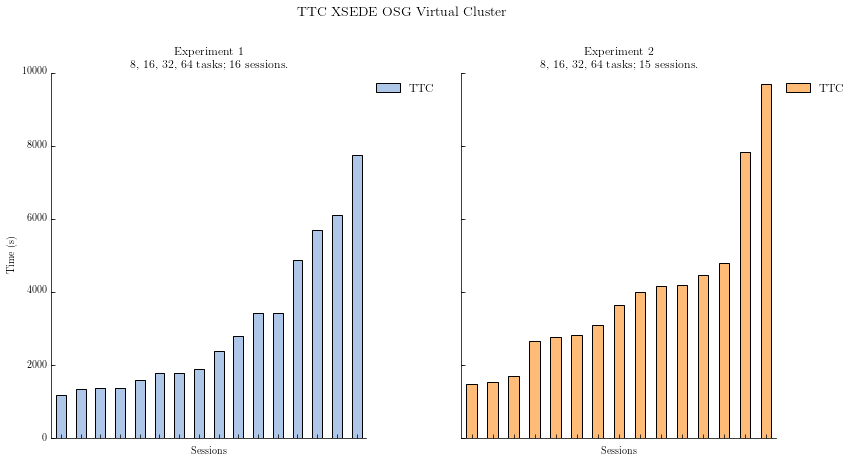

In [9]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTC XSEDE OSG Virtual Cluster', fontsize=14)
plt.subplots_adjust(wspace=0.3, top=0.85)

ttc_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    ttc_subplots.append(sessions[ (sessions['experiment'] == exp) ].sort_values('TTC'))

colors = {'exp1': tableau20[1],
          'exp2': tableau20[3]}

ax = []
for splt in range(2):
    session = ttc_subplots.pop(0)
    experiment = session['experiment'].unique()[0]
    ntasks = ', '.join([str(int(n)) for n in session['nunits'].unique()])
    color = colors[experiment]
    title = 'Experiment %s\n%s tasks; %s sessions.' % (experiment[3], ntasks, session.shape[0])

    if not ax:
        ax.append(fig.add_subplot(1, 2, splt+1))
    else:
        ax.append(fig.add_subplot(1, 2, splt+1, sharey=ax[0]))
    session['TTC'].plot(kind='bar', color=color, ax=ax[splt], title=title)
    ax[splt].spines["top"].set_visible(False)
    ax[splt].spines["right"].set_visible(False)
    ax[splt].get_xaxis().tick_bottom()
    ax[splt].get_yaxis().tick_left()
    ax[splt].set_xticklabels([])
    ax[splt].set_xlabel('Sessions')
    ax[splt].set_ylabel('Time (s)')
    ax[splt].legend(bbox_to_anchor=(1.25, 1))
    fig.add_subplot(ax[splt])
    
plt.savefig('figures/osg_ttc_experiments.pdf', dpi=600, bbox_inches='tight')

Plot and compare runs' TTC, goruped by the number of units for each experiment.

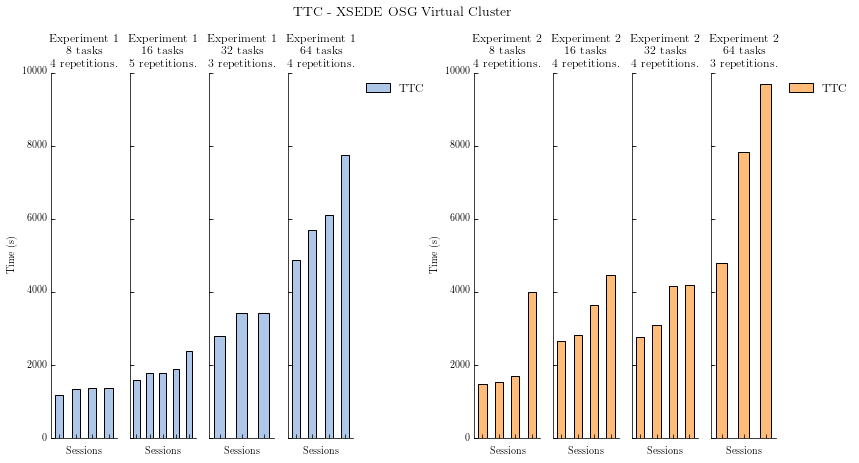

In [10]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTC - XSEDE OSG Virtual Cluster', fontsize=14)

gs = []
grid  = gridspec.GridSpec(1, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))

ttc_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        ttc_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                      (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': tableau20[1],
          'exp2': tableau20[3]}

ax = []
i  = 0
while(i<8):
    for gn in range(2):
        for gc in range(4):
            session = ttc_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            color = colors[experiment]
            title = 'Experiment %s\n%s tasks\n%s repetitions.' % (experiment[3], ntasks, session.shape[0])
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))

            session['TTC'].plot(kind='bar', color=color, ax=ax[i], title=title)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Sessions')
            ax[i].legend(labels=['TTC'], bbox_to_anchor=(2.25, 1))
            ax[i].set_ylabel('Time (s)')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7:
                plt.setp(ax[i].get_yticklabels(), visible=False)
                ax[i].set_ylabel('')
                
            # Handle legens.
            if i != 7 and i != 3:
                ax[i].get_legend().set_visible(False)

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttc_nunits.pdf', dpi=600, bbox_inches='tight')

## Pilot State Model

The 'session' entity is an artifact we created for the analysis. As such, it does not have a state or event model as the other entities of RP. We start by looking at the states of the entity 'pilot' for each session of our experiments.

We test whether the state model of each pilot of every session of all our experiments are the same. In this way we will know:
* whether our data are clean; and
* what states of the pilots we can compare in our analysis given our dataset.

In [11]:
last_sv = None
last_id = None

for s in sessions['session']:
    sv = s.describe('state_values', etype=['pilot']).values()[0].values()[0]
   
    if last_sv and last_sv != sv:
        print "Different state models:\n%s = %s\n%s = %s" % (last_id, last_sv, sid, sv)

    last_sv = sv
    last_id = s._sid
        
pprint.pprint(last_sv)

{-1: None,
 0: 'NEW',
 1: 'PMGR_LAUNCHING_PENDING',
 2: 'PMGR_LAUNCHING',
 3: 'PMGR_ACTIVE_PENDING',
 4: 'PMGR_ACTIVE',
 5: ['CANCELED', 'FAILED', 'DONE']}


## Pilot State Model Interpretation

From the RADICAL-Pilot documentation and state model description, we know that:

<img src="images/global_state_model_rp_paper.png" width="600">

The states of the pilots are therefore as follow:
* pilot described, state **NEW**;
* pilot being queued in a pilot manager (PMGR), state **PMGR_LAUNCHING_PENDING**;
* pilot being queued in a local resource managerment system (LRMS), state **PMGR_LAUNCHING**;
* pilot having a bootstrapping agent, state **PMGR_ACTIVE_PENDING**;
* pilot having an active agent, state **PMGR_ACTIVE**;
* pilot marked as done by the PMGR, state **DONE**.

## Pilot Durations

We define four durations to measure the aggreted time spent by all the pilots in each state:

| Duration           | Start timestamp        | End time Stamp         | Description | 
|--------------------|------------------------|------------------------|----------------|
| TT_PILOT_PMGR_SCHEDULING | NEW                    | PMGR_LAUNCHING_PENDING | total time spent by a pilot being scheduled to a PMGR | 
| TT_PILOT_PMGR_QUEUING    | PMGR_LAUNCHING_PENDING | PMGR_LAUNCHING         | total time spent by a pilot in a PMGR queue |
| TT_PILOT_LRMS_SUBMITTING | PMGR_LAUNCHING         | PMGR_ACTIVE_PENDING    | total time spent by a pilot being submitted to a LRMS |
| TT_PILOT_LRMS_QUEUING    | PMGR_ACTIVE_PENDING    | PMGR_ACTIVE            | total time spent by a pilot being queued in a LRMS queue |
| TT_PILOT_LRMS_RUNNING    | PMGR_ACTIVE            | DONE                   | total time spent by a pilot being active |

We should note that:
* Every state transition can end in state CANCELLED or FAILED, depending on the execution conditions. While this has no bearing on the semantics of the state model, when measuring durations we need to keep that in mind. This is why the API of session.duration() allows for passing **lists** of states as initial and end timestamp. 
* In presence of multiple pilots, the queue time of one or more pilot can overlap, partially overlap, or not overlap at all. When calculating the total amount of queue time for the whole run, we need to account for overlappings and, therefore, for time subtractions or additions. Luckily, the method `session.duration()` does all this for us.

Time to record some durations.

In [12]:
# Model of pilot durations.
pdm = {'TT_PILOT_PMGR_SCHEDULING': ['NEW'                   ,  'PMGR_LAUNCHING_PENDING'],
       'TT_PILOT_PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING',  'PMGR_LAUNCHING'],
       'TT_PILOT_LRMS_SUBMITTING': ['PMGR_LAUNCHING'        ,  'PMGR_ACTIVE_PENDING'],
       'TT_PILOT_LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING'   ,  'PMGR_ACTIVE'],
       'TT_PILOT_LRMS_RUNNING'   : ['PMGR_ACTIVE'           , ['DONE',
                                                               'CANCELED',
                                                               'FAILED']]}
# Add total pilot durations to sessions' DF.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for d in pdm.keys():
        sessions.ix[sid, d] = s.duration(pdm[d])

sessions[['TT_PILOT_PMGR_SCHEDULING', 'TT_PILOT_PMGR_QUEUING', 'TT_PILOT_LRMS_SUBMITTING', 
          'TT_PILOT_LRMS_QUEUING',    'TT_PILOT_LRMS_RUNNING']]

,TT_PILOT_PMGR_SCHEDULING,TT_PILOT_PMGR_QUEUING,TT_PILOT_LRMS_SUBMITTING,TT_PILOT_LRMS_QUEUING,TT_PILOT_LRMS_RUNNING
rp.session.radical.mingtha.017033.0007,0.1115,0.0021,40.8441,449.3611,1331.8193
rp.session.radical.mingtha.017033.0008,0.1159,0.0019,32.6656,173.0403,4716.2959
rp.session.radical.mingtha.017033.0009,0.1041,0.0022,30.7743,236.8754,2602.2942
rp.session.radical.mingtha.017034.0002,0.1143,0.0021,25.5676,231.9484,5939.5228
rp.session.radical.mingtha.017034.0003,0.1173,0.0022,27.1441,229.5577,1613.3759
rp.session.radical.mingtha.017034.0004,0.1200,0.0020,26.4455,230.5590,3223.1165
rp.session.radical.mingtha.017034.0005,0.1347,0.0021,26.2371,248.2416,2136.6846
rp.session.radical.mingtha.017034.0006,0.1218,0.0021,25.5355,258.3061,3202.5680
rp.session.radical.mingtha.017035.0003,0.1030,0.0022,25.5982,269.9133,1636.6105
rp.session.radical.mingtha.017035.0005,0.1026,0.0020,25.7160,245.5325,5472.8325


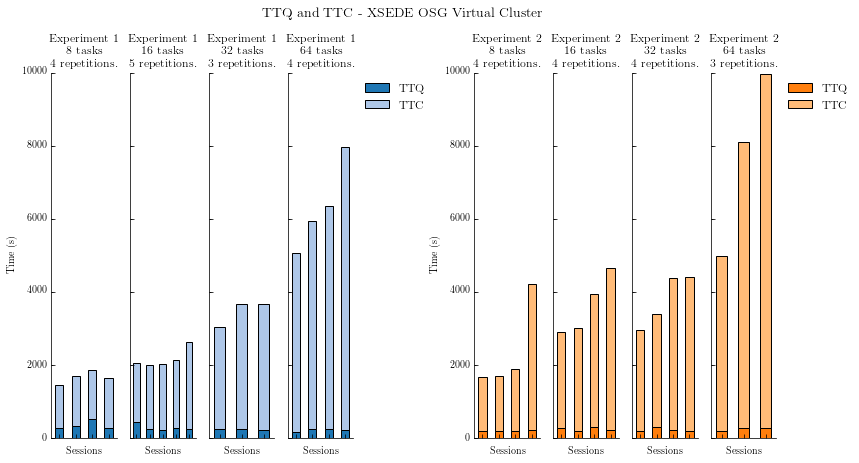

In [13]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTQ and TTC - XSEDE OSG Virtual Cluster', fontsize=14)

gs = []
grid  = gridspec.GridSpec(1, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                      (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0],tableau20[1]],
          'exp2': [tableau20[2],tableau20[3]]}

ax = []
i  = 0
while(i<8):
    for gn in range(2):
        for gc in range(4):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            color = colors[experiment]
            title = 'Experiment %s\n%s tasks\n%s repetitions.' % (experiment[3], ntasks, session.shape[0])
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_PILOT_LRMS_QUEUING', 'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Sessions')
            ax[i].legend(labels=['TTQ','TTC'], bbox_to_anchor=(2.25, 1))            
            ax[i].set_ylabel('Time (s)')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7:
                plt.setp(ax[i].get_yticklabels(), visible=False)
                ax[i].set_ylabel('')
                
            # Handle legens.
            if i != 7 and i != 3:
                ax[i].get_legend().set_visible(False)
            
            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttc_nunits.pdf', dpi=600, bbox_inches='tight')

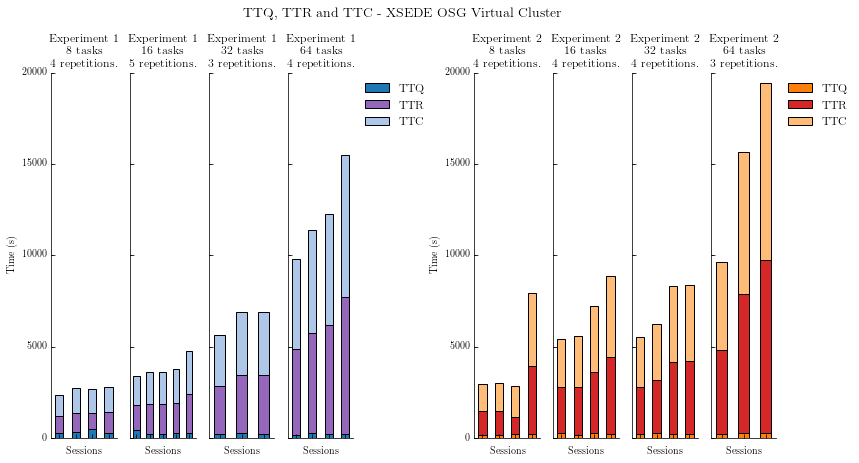

In [14]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTQ, TTR and TTC - XSEDE OSG Virtual Cluster', fontsize=14)

gs = []
grid  = gridspec.GridSpec(1, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                      (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0],tableau20[8],tableau20[1]],
          'exp2': [tableau20[2],tableau20[6],tableau20[3]]}

ax = []
i  = 0
while(i<8):
    for gn in range(2):
        for gc in range(4):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            color = colors[experiment]
            title = 'Experiment %s\n%s tasks\n%s repetitions.' % (experiment[3], ntasks, session.shape[0])
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_PILOT_LRMS_QUEUING', 
                     'TT_PILOT_LRMS_RUNNING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Sessions')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3:
                ax[i].legend(labels=['TTQ','TTR','TTC'], bbox_to_anchor=(2.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
            
            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttr_ttc_nunits.pdf', dpi=600, bbox_inches='tight')

In [15]:
# Temporary: workaround for bug ticket \#15. Calculates 
# the number of active pilots by looking into the 
# length of the list returned by timestamp on the 
# PMGR_ACTIVE state.

for sid in sessions.index:
    sessions.ix[sid, 'npilot_active'] = len(sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False).timestamps(state='PMGR_ACTIVE'))

sessions[['npilot_active']]

,npilot_active
rp.session.radical.mingtha.017033.0007,4.0
rp.session.radical.mingtha.017033.0008,4.0
rp.session.radical.mingtha.017033.0009,4.0
rp.session.radical.mingtha.017034.0002,4.0
rp.session.radical.mingtha.017034.0003,4.0
rp.session.radical.mingtha.017034.0004,4.0
rp.session.radical.mingtha.017034.0005,4.0
rp.session.radical.mingtha.017034.0006,4.0
rp.session.radical.mingtha.017035.0003,4.0
rp.session.radical.mingtha.017035.0005,4.0


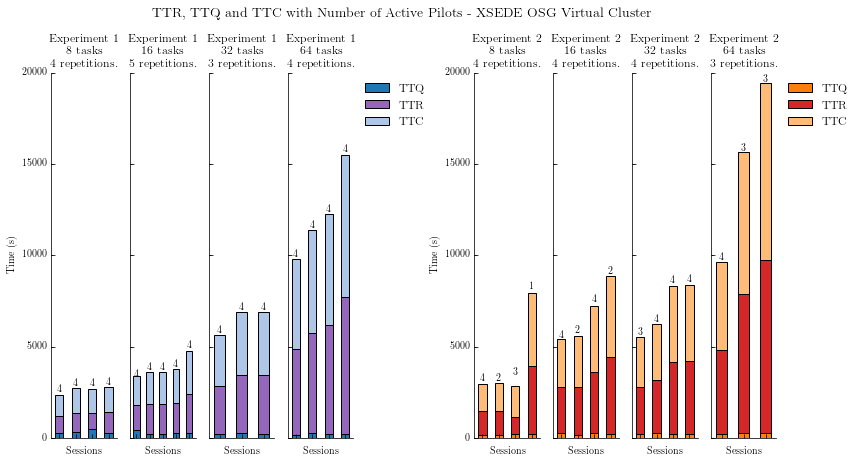

In [16]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTR, TTQ and TTC with Number of Active Pilots - XSEDE OSG Virtual Cluster', fontsize=14)

gs = []
grid  = gridspec.GridSpec(1, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                      (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0],tableau20[8],tableau20[1]],
          'exp2': [tableau20[2],tableau20[6],tableau20[3]]}

ax = []
i  = 0
while(i<8):
    for gn in range(2):
        for gc in range(4):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Experiment %s\n%s tasks\n%s repetitions.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_PILOT_LRMS_QUEUING', 
                     'TT_PILOT_LRMS_RUNNING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Sessions')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3:
                ax[i].legend(labels=['TTQ','TTR','TTC'], bbox_to_anchor=(2.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels with number of pilots per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['npilot_active']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           (height*2), label, ha='center', 
                           va='bottom')

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttr_ttc_npactive_nunits.pdf', dpi=600, bbox_inches='tight')

We measure also Tq for each pilot indipendently. Depending on their overlapping, the overall Tq might be the a value between the sum of 4 indipendent Tq or the value of the longest Tq.

We print also their state models so to check how they performed after leaving the queue. This will give an insight for when we will look at the portion of TTC spent executing units. For example, did units execute on a single pilot or were they distributed across multiple pilots?

In [17]:
# Model of pilot durations.
pdm = {'PMGR_SCHEDULING': ['NEW'                   ,  'PMGR_LAUNCHING_PENDING'],
       'PMGR_QUEUING'   : ['PMGR_LAUNCHING_PENDING',  'PMGR_LAUNCHING'],
       'LRMS_SUBMITTING': ['PMGR_LAUNCHING'        ,  'PMGR_ACTIVE_PENDING'],
       'LRMS_QUEUING'   : ['PMGR_ACTIVE_PENDING'   ,  'PMGR_ACTIVE'],
       'LRMS_RUNNING'   : ['PMGR_ACTIVE'           , ['DONE',
                                                      'CANCELED',
                                                      'FAILED']]}

# DataFrame structure for pilot durations. 
pds = { 'pid': [],
        'sid': [],
        'experiment'     : [],
        'PMGR_SCHEDULING': [],
        'PMGR_QUEUING'   : [],
        'LRMS_SUBMITTING': [],
        'LRMS_QUEUING'   : [],
        'LRMS_RUNNING'   : []}

# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='pilot', inplace=False)
    for p in s.list('uid'):
        sf = s.filter(uid=p, inplace=False)
        pds['pid'].append(p)
        pds['sid'].append(sid)
        pds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in pdm.keys():
            if (not sf.timestamps(state=pdm[d][0]) or 
                not sf.timestamps(state=pdm[d][1])):
                pds[d].append(None)
                continue
            pds[d].append(sf.duration(pdm[d]))

# Populate the DataFrame.
pilots = pd.DataFrame(pds)

pilots

,LRMS_QUEUING,LRMS_RUNNING,LRMS_SUBMITTING,PMGR_QUEUING,PMGR_SCHEDULING,experiment,pid,sid
0,217.2896,1330.7067,40.8441,0.0021,0.1115,exp1,pilot.0002,rp.session.radical.mingtha.017033.0007
1,221.4914,1320.1125,40.8441,0.0021,0.1115,exp1,pilot.0003,rp.session.radical.mingtha.017033.0007
2,449.3611,1096.5372,40.8441,0.0021,0.1115,exp1,pilot.0000,rp.session.radical.mingtha.017033.0007
3,276.1093,1272.9996,40.8441,0.0021,0.1115,exp1,pilot.0001,rp.session.radical.mingtha.017033.0007
4,173.0397,4667.3284,32.6656,0.0019,0.1159,exp1,pilot.0002,rp.session.radical.mingtha.017033.0008
5,173.0403,4669.4392,32.6656,0.0019,0.1159,exp1,pilot.0003,rp.session.radical.mingtha.017033.0008
6,172.0393,4665.1039,32.6656,0.0019,0.1159,exp1,pilot.0000,rp.session.radical.mingtha.017033.0008
7,126.1836,4707.8528,32.6656,0.0019,0.1159,exp1,pilot.0001,rp.session.radical.mingtha.017033.0008
8,154.5699,2600.2818,30.7743,0.0022,0.1041,exp1,pilot.0002,rp.session.radical.mingtha.017033.0009
9,236.8754,2516.9717,30.7743,0.0022,0.1041,exp1,pilot.0003,rp.session.radical.mingtha.017033.0009


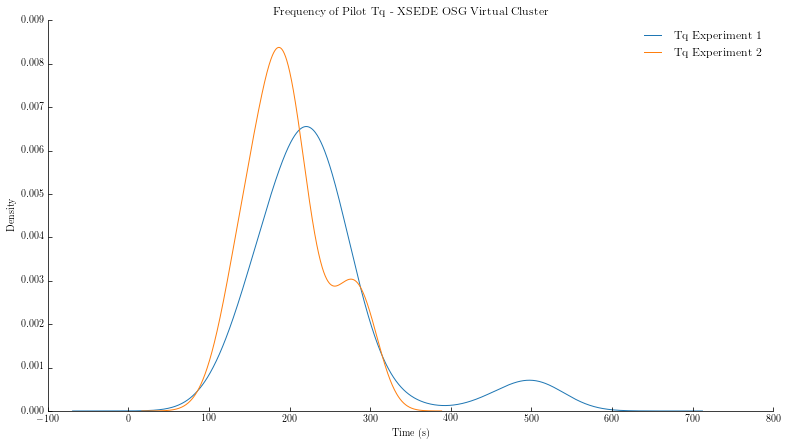

In [18]:
ax = fig_setup()
title='Frequency of Pilot Tq - XSEDE OSG Virtual Cluster'
pilots[pilots['experiment'].str.contains('exp1')]['LRMS_QUEUING'].dropna().plot.kde(ax=ax, 
                                                                                    color=tableau20[0], 
                                                                                    title=title)
pilots[pilots['experiment'].str.contains('exp2')]['LRMS_QUEUING'].dropna().plot.kde(ax=ax, 
                                                                                    color=tableau20[2])
ax.set_xlabel('Time (s)')
ax.legend(labels=['Tq Experiment 1','Tq Experiment 2'])

plt.savefig('figures/osg_tq_frequency.pdf', dpi=600, bbox_inches='tight')

We now look at the states of the entity 'unit':

In [19]:
last_sv = None
last_id = None

for s in sessions['session']:
    sv = s.describe('state_values', etype=['unit']).values()[0].values()[0]
   
    if last_sv and last_sv != sv:
        print "Different state models:\n%s = %s\n%s = %s" % (last_id, last_sv, sid, sv)

    last_sv = sv
    last_id = s._sid
        
pprint.pprint(last_sv)

{-1: None,
 0: 'NEW',
 1: 'UMGR_SCHEDULING_PENDING',
 2: 'UMGR_SCHEDULING',
 3: 'UMGR_STAGING_INPUT_PENDING',
 4: 'UMGR_STAGING_INPUT',
 5: 'AGENT_STAGING_INPUT_PENDING',
 6: 'AGENT_STAGING_INPUT',
 7: 'AGENT_SCHEDULING_PENDING',
 8: 'AGENT_SCHEDULING',
 9: 'AGENT_EXECUTING_PENDING',
 10: 'AGENT_EXECUTING',
 11: 'AGENT_STAGING_OUTPUT_PENDING',
 12: 'AGENT_STAGING_OUTPUT',
 13: 'UMGR_STAGING_OUTPUT_PENDING',
 14: 'UMGR_STAGING_OUTPUT',
 15: ['CANCELED', 'DONE', 'FAILED']}


## Unit State Model Interpretation

From the RADICAL-Pilot documentation and state model description, we know that:

<img src="images/global_state_model_rp_paper.png" width="600">

The states of the units are therefore as follow:
* unit described, state **NEW**;
* unit queuing in a unit manager (UMGR)'s queue, state **UMGR_SCHEDULING_PENDING**;
* unit being scheduled by a UMGR to an active pilot agent, state **UMGR_SCHEDULING**;
* input file(s) of a scheduling unit queuing in a UMGR's queue, state **UMGR_STAGING_INPUT_PENDING**;
* input file(s) of a scheduling unit being staged to a (pilot) agent's MongoDB queue. The agent is the same on which the input file(s)' unit is being scheduled, state **UMGR_STAGING_INPUT**;
* input file(s) of a scheduling unit queuing in the (pilot) agent's MongoDB queue. The agent is the same on which the input file(s)' unit is being scheduled, state **AGENT_STAGING_INPUT_PENDING**;
* input file(s) of a scheduling unit being staged to an agent's resource. The agent is the same on which the input file(s)' unit is being scheduled, state **AGENT_STAGING_INPUT**; 
* unit queueing in a agent's queue, state **AGENT_SCHEDULING_PENDING**;
* unit being scheduled by the agent for execution on pilot's resources, state **AGENT_SCHEDULING**;
* unit queueing in a agent's queue, state **AGENT_EXECUTING_PENDING**;
* unit being executed by the agent on pilot's resources, state **AGENT_EXECUTING**;
* output file(s) of an executed unit queuing on an agent's queue, state **AGENT_STAGING_OUTPUT_PENDING**;
* output file(s) of an executed unit being staged on a UMGR's MongoDB queue, state **AGENT_STAGING_OUTPUT**;
* output file(s) of an executed unit queuing on a UMGR's MongoDB queue, state **UMGR_STAGING_OUTPUT_PENDING**;
* output file(s) of an executed unit being staged on a UMGR's resource (e.g., user's workstation), state **UMGR_STAGING_OUTPUT**;
* unit marked as done by a UMGR, state **DONE**.


## Unit Durations

We define 15 durations to measure the aggreted time spent by all the units of a session in each state:

| Duration                           | Start timestamp              | End time Stamp               | Description |
|------------------------------------|------------------------------|------------------------------|-------------|
| TT_UNIT_UMGR_SCHEDULING            | NEW                          | UMGR_SCHEDULING_PENDING      | total time spent by a unit being scheduled to a UMGR | 
| TT_UNIT_UMGR_BINDING               | UMGR_SCHEDULING_PENDING      | UMGR_SCHEDULING              | total time spent by a unit being bound to a pilot by a UMGR | 
| TT_IF_UMGR_SCHEDULING              | UMGR_SCHEDULING              | UMGR_STAGING_INPUT_PENDING   | total time spent by input file(s) being scheduled to a UMGR | 
| TT_IF_UMGR_QUEING                  | UMGR_STAGING_INPUT_PENDING   | UMGR_STAGING_INPUT           | total time spent by input file(s) queuing in a UMGR | 
| TT_IF_AGENT_SCHEDULING             | UMGR_STAGING_INPUT           | AGENT_STAGING_INPUT_PENDING  | total time spent by input file(s) being scheduled to an agent's MongoDB queue |
| TT_IF_AGENT_QUEUING                | AGENT_STAGING_INPUT_PENDING  | AGENT_STAGING_INPUT          | total time spent by input file(s) queuing in an agent's MongoDB queue |
| TT_IF_AGENT_TRANSFERRING           | AGENT_STAGING_INPUT          | AGENT_SCHEDULING_PENDING     | total time spent by input file(s)' payload to be transferred from where the UMGR is being executed (e.g., the user's workstation) to the resource on which the agent is executing |
| TT_UNIT_AGENT_QUEUING              | AGENT_SCHEDULING_PENDING     | AGENT_SCHEDULING             | total time spent by a unit in the agent's scheduling queue | 
| TT_UNIT_AGENT_SCHEDULING           | AGENT_SCHEDULING             | AGENT_EXECUTING_PENDING      | total time spent by a unit to be scheduled to the agent's executing queue | 
| TT_UNIT_AGENT_QUEUING_EXECUTION    | AGENT_EXECUTING_PENDING      | AGENT_EXECUTING              | total time spent by a unit in the agent's executing queue  |
| TT_UNIT_AGENT_EXECUTING            | AGENT_EXECUTING              | AGENT_STAGING_OUTPUT_PENDING | total time spent by a unit executing |
| TT_OF_AGENT_QUEUING                | AGENT_STAGING_OUTPUT_PENDING | AGENT_STAGING_OUTPUT         | total time spent by output file(s) queuing in the agent's stage out queue |
| TT_OF_UMGR_SCHEDULING              | AGENT_STAGING_OUTPUT         | UMGR_STAGING_OUTPUT_PENDING  | total time spent by output file(s) being scheduled to a UMGR's MongoDB queue |
| TT_OF_UMGR_QUEUING                 | UMGR_STAGING_OUTPUT_PENDING  | UMGR_STAGING_OUTPUT          | total time spent by output file(s) queuing in a UMGR's MongoDB queue |
| TT_OF_UMGR_TRANSFERRING            | UMGR_STAGING_OUTPUT          | DONE                         | total time spent by output file(s)' payload to be transferred from the resource to where the UMGR is being executed (e.g., the user's workstation) |

## Unit Durations Aggregates

Durations can be aggregated so to represent a middle-level semantics:

```
* TT_UNIT_RP_OVERHEAD    = TT_UMGR_UNIT_SCHEDULING         + 
                           TT_AGENT_UNIT_QUEUING           + 
                           TT_AGENT_UNIT_SCHEDULING        + 
                           TT_AGENT_UNIT_QUEUING_EXECUTION
                          
* TT_IF_RP_OVERHEAD      = TT_UMGR_IF_SCHEDULING           +
                           TT_UMGR_IF_QUEING               +
                           TT_AGENT_IF_QUEUING

* TT_OF_RP_OVERHEAD      = TT_AGENT_OF_QUEUING             +
                           TT_UMGR_OF_QUEING               +

* TT_IF_NETWORK_OVERHEAD = TT_AGENT_IF_SCHEDULING          +
                           TT_AGENT_IF_TRANSFERRING

* TT_OF_NETWORK_OVERHEAD = TT_UMGR_OF_SCHEDULING           +
                           TT_UMGR_OF_TRANSFERRING

* TT_IF_STAGING          = TT_IF_RP_OVERHEAD               +
                           TT_IF_NETWORK_OVERHEAD

* TT_OF_STAGING          = TT_OF_RP_OVERHEAD               +
                           TT_OF_NETWORK_OVERHEAD
```
and higher-level semantics:
```
* TT_RP_OVERHEADS        = TT_UNIT_RP_OVERHEAD             + 
                           TT_IF_RP_OVERHEAD               + 
                           TT_OF_RP_OVERHEAD

* TT_NETWORK_OVERHEADS   = TT_IF_NETWORK_OVERHEAD          +
                           TT_OF_NETWORK_OVERHEAD

* TT_FILE_STAGING        = TT_IF_STAGING                   + 
                           TT_OF_STAGING

* TT_UNIT_EXECUTING      = TT_AGENT_UNIT_EXECUTING
```

## Consistency Rules

Note that we can derive consistency constraints from these models. For every session, the following has always to be true:


As done with the pilot, we first calculate the overall time spent during the session to execute CUs.

In [20]:
# Model of unit durations.
udm = {'TT_UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
       'TT_UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
       'TT_IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
       'TT_IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
       'TT_IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
       'TT_IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
       'TT_IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
       'TT_UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
       'TT_UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
       'TT_UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
       'TT_UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING'], 
       'TT_OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
       'TT_OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
       'TT_OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
       'TT_OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

# Calculate total unit durations for each session.
for sid in sessions.index:
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
    for d in udm.keys():
        sessions.ix[sid, d] = s.duration(udm[d])

# Print the new columns of the session DF with total unit durations.
sessions[['TT_UNIT_UMGR_SCHEDULING'   , 'TT_UNIT_UMGR_BINDING'   , 'TT_IF_UMGR_SCHEDULING'   , 
          'TT_IF_UMGR_QUEING'         , 'TT_IF_AGENT_SCHEDULING' , 'TT_IF_AGENT_QUEUING'     , 
          'TT_IF_AGENT_TRANSFERRING'  , 'TT_UNIT_AGENT_QUEUING'  , 'TT_UNIT_AGENT_SCHEDULING', 
          'TT_UNIT_AGENT_QUEUING_EXEC', 'TT_UNIT_AGENT_EXECUTING', 'TT_OF_AGENT_QUEUING'     , 
          'TT_OF_UMGR_SCHEDULING'     , 'TT_OF_UMGR_QUEUING'     , 'TT_OF_UMGR_TRANSFERRING']]

,TT_UNIT_UMGR_SCHEDULING,TT_UNIT_UMGR_BINDING,TT_IF_UMGR_SCHEDULING,TT_IF_UMGR_QUEING,TT_IF_AGENT_SCHEDULING,TT_IF_AGENT_QUEUING,TT_IF_AGENT_TRANSFERRING,TT_UNIT_AGENT_QUEUING,TT_UNIT_AGENT_SCHEDULING,TT_UNIT_AGENT_QUEUING_EXEC,TT_UNIT_AGENT_EXECUTING,TT_OF_AGENT_QUEUING,TT_OF_UMGR_SCHEDULING,TT_OF_UMGR_QUEUING,TT_OF_UMGR_TRANSFERRING
rp.session.radical.mingtha.017033.0007,0.2603,0.0073,893.4051,0.014800,0.003800,82.808800,15.981700,0.009500,954.9375,0.008100,1293.900700,30.080999,0.000900,0.616500,0.004000
rp.session.radical.mingtha.017033.0008,0.4086,0.0375,4049.1254,0.069201,0.017399,475.426100,93.534100,0.033500,4282.6453,0.034600,4681.268900,81.947199,0.010900,6.946100,0.017699
rp.session.radical.mingtha.017033.0009,0.9616,0.0105,2038.6201,0.032899,0.008401,169.370499,43.697901,0.016799,2212.1315,0.017800,2574.208900,44.730300,0.012500,7.040701,0.008899
rp.session.radical.mingtha.017034.0002,0.5175,0.0215,5126.3862,0.071301,0.016299,441.915800,87.543300,0.032100,5430.9320,0.033800,5909.719600,95.687300,0.010200,6.915001,0.017500
rp.session.radical.mingtha.017034.0003,0.7658,0.0086,1062.0936,0.015400,0.003999,91.912000,22.030800,0.008700,1183.9320,0.009501,1581.196700,21.875100,0.003700,2.545500,0.004400
rp.session.radical.mingtha.017034.0004,0.2989,0.0143,2225.9059,0.033200,0.008900,176.711000,43.078600,0.016700,2500.1372,0.017400,2978.923900,41.294501,0.012600,7.174799,0.008101
rp.session.radical.mingtha.017034.0005,0.2287,0.0080,1036.2253,0.015700,0.004301,81.200900,18.199600,0.008900,1282.4557,0.009000,1884.117200,20.304500,1.716700,1.761700,0.004700
rp.session.radical.mingtha.017034.0006,0.2865,0.0153,2385.6185,0.033099,0.008500,182.907200,42.381901,0.016700,2568.4641,0.017100,3171.114200,41.871001,0.011800,6.990100,0.009200
rp.session.radical.mingtha.017035.0003,0.2539,0.0094,1061.3728,0.015801,0.005199,85.414800,16.241700,0.008300,1019.0096,0.008700,1396.230600,19.423199,0.005200,3.826101,0.004900
rp.session.radical.mingtha.017035.0005,0.4136,0.0219,5036.2223,0.072098,0.017700,437.184401,79.867301,0.033799,5075.8293,1.048799,5443.032800,99.212500,0.012099,7.824301,0.016900


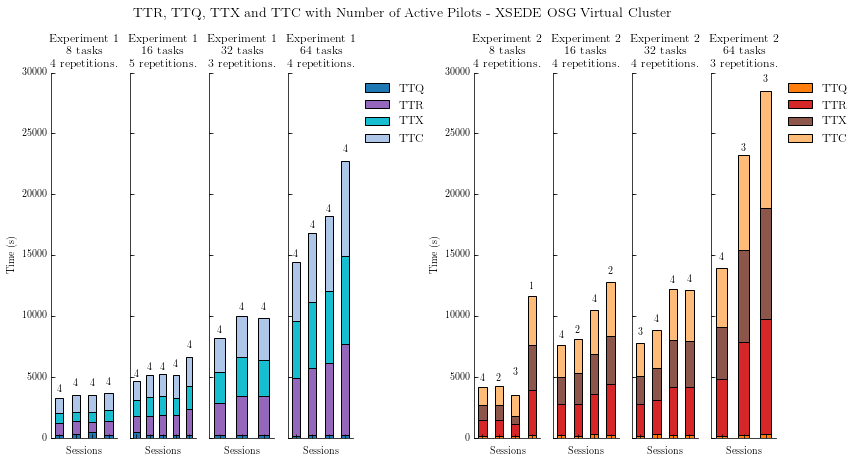

In [21]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTR, TTQ, TTX and TTC with Number of Active Pilots - XSEDE OSG Virtual Cluster', fontsize=14)

gs = []
grid  = gridspec.GridSpec(1, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                      (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[0],tableau20[8],tableau20[18],tableau20[1]],
          'exp2': [tableau20[2],tableau20[6],tableau20[10],tableau20[3]]}

ax = []
i  = 0
while(i<8):
    for gn in range(2):
        for gc in range(4):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Experiment %s\n%s tasks\n%s repetitions.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_PILOT_LRMS_QUEUING', 
                     'TT_PILOT_LRMS_RUNNING',
                     'TT_UNIT_AGENT_EXECUTING',
                     'TTC']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Sessions')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3:
                ax[i].legend(labels=['TTQ','TTR','TTX','TTC'], bbox_to_anchor=(2.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels with number of pilots per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['npilot_active']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           (height*3), label, ha='center', 
                           va='bottom')

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttq_ttr_ttx_ttc_npactive_nunits.pdf', dpi=600, bbox_inches='tight')

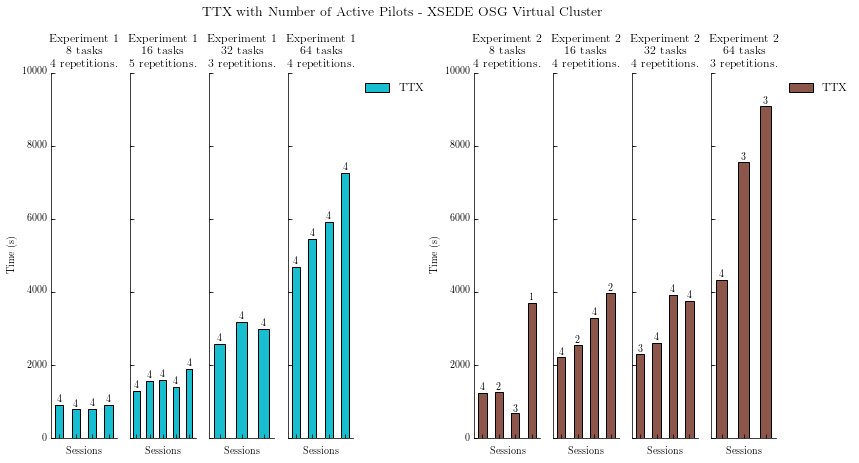

In [22]:
fig = plt.figure(figsize=(13,7))
fig.suptitle('TTX with Number of Active Pilots - XSEDE OSG Virtual Cluster', fontsize=14)

gs = []
grid  = gridspec.GridSpec(1, 2)
grid.update(wspace=0.4, top=0.85)
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[0]))
gs.append(gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=grid[1]))

ttq_subplots = []
for exp in sessions['experiment'].sort_values().unique():
    for nun in sessions['nunits'].sort_values().unique():
        ttq_subplots.append(sessions[ (sessions['experiment'] == exp) & 
                                      (sessions['nunits'] == nun) ].sort_values('TTC'))

colors = {'exp1': [tableau20[18]],
          'exp2': [tableau20[10]]}

ax = []
i  = 0
while(i<8):
    for gn in range(2):
        for gc in range(4):
            session = ttq_subplots.pop(0)
            experiment = session['experiment'].unique()[0]
            ntasks = int(session['nunits'].unique()[0])
            repetitions = session.shape[0]
            color = colors[experiment]
            title = 'Experiment %s\n%s tasks\n%s repetitions.' % (experiment[3], ntasks, repetitions)
            
            if i == 0:
                ax.append(plt.Subplot(fig, gs[gn][0, gc]))
            else:
                ax.append(plt.Subplot(fig, gs[gn][0, gc], sharey=ax[0]))
            session[['TT_UNIT_AGENT_EXECUTING']].plot(kind='bar', ax=ax[i], color=color, title=title, stacked=True)
            ax[i].spines["top"].set_visible(False)
            ax[i].spines["right"].set_visible(False)
            ax[i].get_xaxis().tick_bottom()
            ax[i].get_yaxis().tick_left()
            ax[i].set_xticklabels([])
            ax[i].set_xlabel('Sessions')
            
            # Handle a bug that sets yticklabels to visible 
            # for the last subplot.
            if i == 7:
                plt.setp(ax[i].get_yticklabels(), visible=False)
            else:
                ax[i].set_ylabel('Time (s)')
                
            # Handle legens.
            if i == 7 or i == 3:
                ax[i].legend(labels=['TTX'], bbox_to_anchor=(2.25, 1))
            else:
                ax[i].get_legend().set_visible(False)
                
            # Add labels with number of pilots per session.
            rects = ax[i].patches
            labels = [int(l) for l in session['npilot_active']]
            for rect, label in zip(rects[-repetitions:], labels):
                height = rect.get_height()
                ax[i].text(rect.get_x() + rect.get_width()/2, 
                           height+0.5, label, ha='center', 
                           va='bottom')

            fig.add_subplot(ax[i])
            i += 1

plt.savefig('figures/osg_ttx_npactive_nunits.pdf', dpi=600, bbox_inches='tight')

We measure also Tx for each unit indipendently.

In [23]:
# Model of unit durations.
udm = {'UNIT_UMGR_SCHEDULING'   : ['NEW'                         , 'UMGR_SCHEDULING_PENDING'],
       'UNIT_UMGR_BINDING'      : ['UMGR_SCHEDULING_PENDING'     , 'UMGR_SCHEDULING'],
       'IF_UMGR_SCHEDULING'     : ['UMGR_SCHEDULING'             , 'UMGR_STAGING_INPUT_PENDING'], 
       'IF_UMGR_QUEING'         : ['UMGR_STAGING_INPUT_PENDING'  , 'UMGR_STAGING_INPUT'],
       #'IF_AGENT_SCHEDULING'    : ['UMGR_STAGING_INPUT'          , 'AGENT_STAGING_INPUT_PENDING'],  
       'IF_AGENT_QUEUING'       : ['AGENT_STAGING_INPUT_PENDING' , 'AGENT_STAGING_INPUT'], 
       'IF_AGENT_TRANSFERRING'  : ['AGENT_STAGING_INPUT'         , 'AGENT_SCHEDULING_PENDING'],
       'UNIT_AGENT_QUEUING'     : ['AGENT_SCHEDULING_PENDING'    , 'AGENT_SCHEDULING'],
       'UNIT_AGENT_SCHEDULING'  : ['AGENT_SCHEDULING'            , 'AGENT_EXECUTING_PENDING'], 
       'UNIT_AGENT_QUEUING_EXEC': ['AGENT_EXECUTING_PENDING'     , 'AGENT_EXECUTING'], 
       'UNIT_AGENT_EXECUTING'   : ['AGENT_EXECUTING'             , 'AGENT_STAGING_OUTPUT_PENDING'], 
       'OF_AGENT_QUEUING'       : ['AGENT_STAGING_OUTPUT_PENDING', 'AGENT_STAGING_OUTPUT'], 
       #'OF_UMGR_SCHEDULING'     : ['AGENT_STAGING_OUTPUT'        , 'UMGR_STAGING_OUTPUT_PENDING'],
       'OF_UMGR_QUEUING'        : ['UMGR_STAGING_OUTPUT_PENDING' , 'UMGR_STAGING_OUTPUT'],
       'OF_UMGR_TRANSFERRING'   : ['UMGR_STAGING_OUTPUT'         , 'DONE']}

# DataFrame structure for pilot durations. 
uds = { 'pid': [],
        'sid': [],
        'experiment' : [],
        'UNIT_UMGR_SCHEDULING'   : [],
        'UNIT_UMGR_BINDING'      : [],
        'IF_UMGR_SCHEDULING'     : [], 
        'IF_UMGR_QUEING'         : [],
        'IF_AGENT_SCHEDULING'    : [],
        'IF_AGENT_QUEUING'       : [], 
        'IF_AGENT_TRANSFERRING'  : [],
        'UNIT_AGENT_QUEUING'     : [],
        'UNIT_AGENT_SCHEDULING'  : [], 
        'UNIT_AGENT_QUEUING_EXEC': [], 
        'UNIT_AGENT_EXECUTING'   : [], 
        'OF_AGENT_QUEUING'       : [], 
        'OF_UMGR_SCHEDULING'     : [],
        'OF_UMGR_QUEUING'        : [],
        'OF_UMGR_TRANSFERRING'   : []}

# Calculate the duration for each state of each 
# pilot of each run and Populate the DataFrame 
# structure.
for sid in sessions[['session', 'experiment']].index:
    s = sessions.ix[sid, 'session'].filter(etype='unit', inplace=False)
    for u in s.list('uid'):
        sf = s.filter(uid=u, inplace=False)
        uds['pid'].append(u)
        uds['sid'].append(sid)
        uds['experiment'].append(sessions.ix[sid, 'experiment'])
        for d in udm.keys():
#             print sid
#             print udm[d]
            if (not sf.timestamps(state=udm[d][0]) or 
                not sf.timestamps(state=udm[d][1])):
                pds[d].append(None)
                print udm[d]
                continue
#             print sf.timestamps(state=udm[d][0])
#             print sf.timestamps(state=udm[d][1])
            uds[d].append(sf.duration(udm[d]))

# Populate the DataFrame. We have empty lists 
units = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in uds.iteritems()]))

units

,IF_AGENT_QUEUING,IF_AGENT_SCHEDULING,IF_AGENT_TRANSFERRING,IF_UMGR_QUEING,IF_UMGR_SCHEDULING,OF_AGENT_QUEUING,OF_UMGR_QUEUING,OF_UMGR_SCHEDULING,OF_UMGR_TRANSFERRING,UNIT_AGENT_EXECUTING,UNIT_AGENT_QUEUING,UNIT_AGENT_QUEUING_EXEC,UNIT_AGENT_SCHEDULING,UNIT_UMGR_BINDING,UNIT_UMGR_SCHEDULING,experiment,pid,sid
0,7.7788,NaN,2.1007,0.0016,270.2836,1.4217,0.0015,NaN,0.0002,208.2497,0.0005,0.0006,239.8848,0.0073,0.2526,exp1,unit.000009,rp.session.radical.mingtha.017033.0007
1,7.7801,NaN,2.1016,0.0016,270.2836,2.3994,0.0023,NaN,0.0003,237.4838,0.0006,0.0007,0.0010,0.0073,0.2534,exp1,unit.000008,rp.session.radical.mingtha.017033.0007
2,8.2666,NaN,2.1026,0.0015,315.0004,2.1495,0.0014,NaN,0.0002,247.4090,0.0004,0.0005,294.9504,0.0073,0.2517,exp1,unit.000010,rp.session.radical.mingtha.017033.0007
3,10.4191,NaN,2.1790,0.0015,488.2521,2.1481,0.0013,NaN,0.0003,340.2051,0.0014,0.0004,390.8832,0.0073,0.2508,exp1,unit.000011,rp.session.radical.mingtha.017033.0007
4,9.2174,NaN,2.0955,0.0011,519.8678,1.0883,0.0014,NaN,0.0003,212.2582,0.0006,0.0005,199.3102,0.0073,0.2499,exp1,unit.000012,rp.session.radical.mingtha.017033.0007
5,8.8606,NaN,0.0004,0.0013,270.2872,1.1276,0.2948,NaN,0.0003,194.5910,0.0007,0.0005,220.9757,0.0073,0.2491,exp1,unit.000013,rp.session.radical.mingtha.017033.0007
6,10.1536,NaN,1.0651,0.0013,729.7243,2.4512,0.0019,NaN,0.0002,203.5250,0.0005,0.0004,202.8926,0.0073,0.2483,exp1,unit.000014,rp.session.radical.mingtha.017033.0007
7,8.1660,NaN,1.4325,0.0012,891.4171,1.4431,0.0015,NaN,0.0002,338.9605,0.0006,0.0005,333.0696,0.0073,0.2475,exp1,unit.000015,rp.session.radical.mingtha.017033.0007
8,6.1805,NaN,1.4329,0.0009,893.4051,2.0678,0.0011,NaN,0.0002,191.2862,0.0005,0.0005,195.2848,0.0073,0.2560,exp1,unit.000005,rp.session.radical.mingtha.017033.0007
9,4.4402,NaN,1.8642,0.0007,869.5619,2.2758,0.0017,NaN,0.0003,281.2242,0.0005,0.0004,304.6255,0.0073,0.2552,exp1,unit.000006,rp.session.radical.mingtha.017033.0007


## Statistics

We now have two set of measures that we can use to do some statistics. 

### Descriptive
#### Measures of Center
* mean ($\mu$)
* standard error of the mean (SEM) 
* median 
* mode

In [24]:
def measures_of_center(durations):
    m = {}
    m['mu']     = np.mean(durations)
    m['sem']    = sps.sem(durations)
    m['median'] = np.median(durations)
    m['mode']   = sps.mstats.mode(durations)

    return m

Txs      = units['UNIT_AGENT_EXECUTING']
Txs_exp1 = units[ units['experiment'] == 'exp1']['UNIT_AGENT_EXECUTING']
Txs_exp2 = units[ units['experiment'] == 'exp2']['UNIT_AGENT_EXECUTING']

Txs      = sorted(Txs)
Txs_exp1 = sorted(Txs_exp1)
Txs_exp2 = sorted(Txs_exp2)

Tx_measures = measures_of_center(Txs)
Tx_measures_exp1 = measures_of_center(Txs_exp1)
Tx_measures_exp2 = measures_of_center(Txs_exp2)

print 'Tx'
pprint.pprint(Tx_measures)
print '\nTx_exp1'
pprint.pprint(Tx_measures_exp1)
print '\nTx_exp2'
pprint.pprint(Tx_measures_exp2)

Tx
{'median': 307.2835499048233,
 'mode': ModeResult(mode=array([ 284.2823]), count=array([ 2.])),
 'mu': 345.61895590668377,
 'sem': 4.7171758088926028}

Tx_exp1
{'median': 326.2800999879837,
 'mode': ModeResult(mode=array([ 189.60710001]), count=array([ 1.])),
 'mu': 337.00376508513403,
 'sem': 4.558952139470728}

Tx_exp2
{'median': 299.42369997501373,
 'mode': ModeResult(mode=array([ 284.2823]), count=array([ 2.])),
 'mu': 355.22820720764309,
 'sem': 8.5682138132476346}


#### Measures of Spread

* range
* percentiles
* interquartile (IRQ)
* variance
* standard deviation ($\sigma$)
* median absolute deviation (MAD)

{'irq': 160.38025003671646,
 'mad': 108.9728196089644,
 'max': 1258.6105000972748,
 'median': 307.2835499048233,
 'min': 185.20440006256104,
 'mode': ModeResult(mode=array([ 284.2823]), count=array([ 2.])),
 'mu': 345.61895590668377,
 'q1': 249.17879998683929,
 'q2': 307.2835499048233,
 'q3': 409.55905002355576,
 'range': 1073.4061000347137,
 'sem': 4.7171758088926028,
 'std': 139.85451780671724,
 'var': 19559.286150949389}
{'irq': 137.66127502918243,
 'mad': 105.57499198853029,
 'max': 673.24180006980896,
 'median': 326.2800999879837,
 'min': 189.60710000991821,
 'mode': ModeResult(mode=array([ 189.60710001]), count=array([ 1.])),
 'mu': 337.00376508513403,
 'q1': 268.99462503194809,
 'q2': 326.2800999879837,
 'q3': 406.65590006113052,
 'range': 483.63470005989075,
 'sem': 4.558952139470728,
 'std': 98.096955377947026,
 'var': 9623.0126544229297}
{'irq': 178.28755003213882,
 'mad': 109.40003154511911,
 'max': 1258.6105000972748,
 'median': 299.42369997501373,
 'min': 185.2044000625610

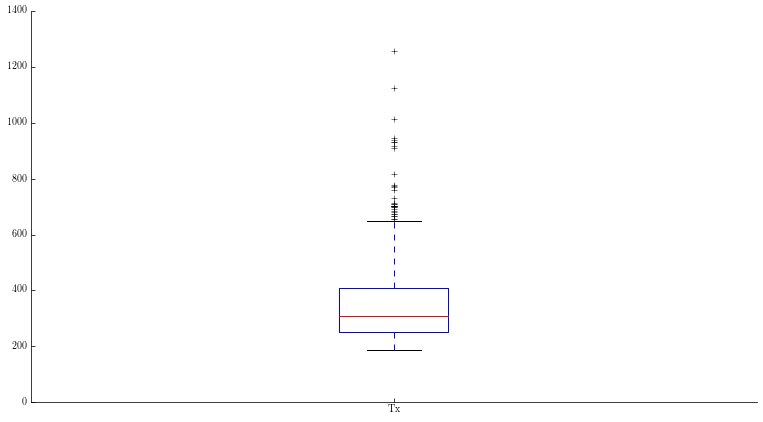

In [25]:
def measures_of_spread(durations):
    m = {}
    m['range'] = max(durations)-min(durations)
    m['min'], m['q1'], m['q2'], m['q3'], m['max'] = np.percentile(durations, [0,25,50,75,100])
    m['irq'] = m['q3'] - m['q1']
    m['var'] = np.var(durations)
    m['std'] = np.std(durations)
    m['mad'] = sm.robust.scale.mad(durations)

    return m

Tx_measures.update(measures_of_spread(Txs))
Tx_measures_exp1.update(measures_of_spread(Txs_exp1))
Tx_measures_exp2.update(measures_of_spread(Txs_exp2))
pprint.pprint(Tx_measures)
pprint.pprint(Tx_measures_exp1)
pprint.pprint(Tx_measures_exp2)


# MOVE TO DISTRIBUTIONS' ANALYSIS
plot = fig_setup()
plot.boxplot(Txs, labels=['Tx'])#, showmeans=True, showcaps=True)

plt.savefig('figures/osg_cu_spread_box.pdf', dpi=600, bbox_inches='tight')

# - Mann-Whitney-Wilcoxon (MWW) RankSum test: determine 
#   whether two distributions are significantly 
#   different or not. Unlike the t-test, the RankSum 
#   test does not assume that the data are normally 
#   distributed. How do we interpret the difference?
x = np.linspace(min(Txs),max(Txs),len(Txs))
Txs_pdf = mlab.normpdf(x, Tx_measures['mu'], Tx_measures['std'])
z_stat, p_val = sps.ranksums(Txs, Txs_pdf)

## Skewness and Kurtosis

1.80607071019
5.17641324125
SkewtestResult(statistic=15.379974013935509, pvalue=2.2303715639832609e-53)
KurtosistestResult(statistic=10.350368125501323, pvalue=4.1687977791076851e-25)


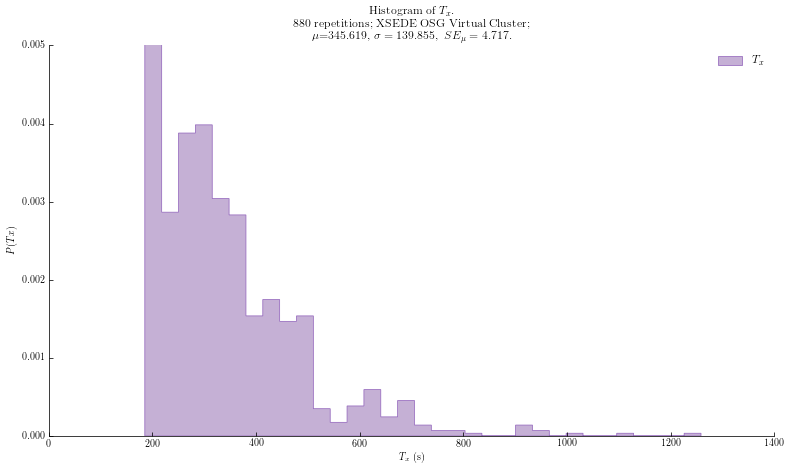

In [26]:
Tx_measures['skew'] = sps.skew(Txs, bias=True)
Tx_measures['kurt'] = sps.kurtosis(Txs)

u_skew_test = sps.skewtest(Txs)
u_kurt_test = sps.kurtosistest(Txs)

print Tx_measures['skew']
print Tx_measures['kurt']

print u_skew_test
print u_kurt_test

metric      = 'T_x'
description = 'Histogram of $%s$' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, patches = ax.hist(Txs, bins='fd',
        normed=1,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.set_xlim(150, 700)
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('figures/osg_cu_spread_hist.pdf', dpi=600, bbox_inches='tight')

1.80607071019
5.17641324125
SkewtestResult(statistic=15.379974013935509, pvalue=2.2303715639832609e-53)
KurtosistestResult(statistic=10.350368125501323, pvalue=4.1687977791076851e-25)


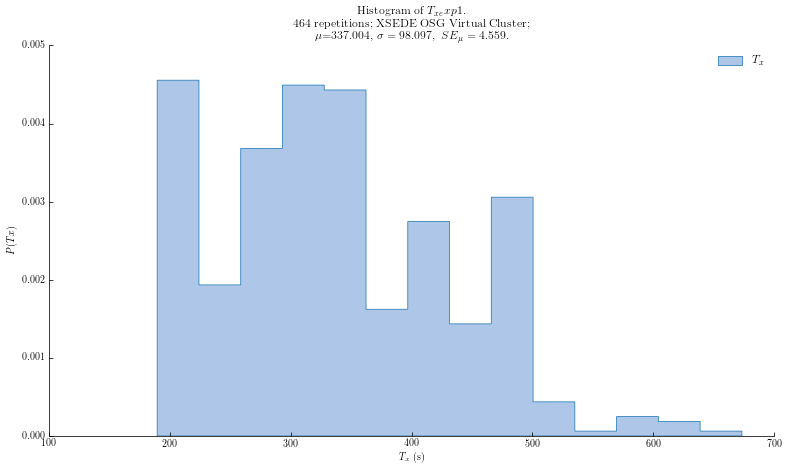

In [27]:
Tx_measures_exp1['skew'] = sps.skew(Txs, bias=True)
Tx_measures_exp1['kurt'] = sps.kurtosis(Txs)

u_skew_test = sps.skewtest(Txs)
u_kurt_test = sps.kurtosistest(Txs)

print Tx_measures_exp1['skew']
print Tx_measures_exp1['kurt']

print u_skew_test
print u_kurt_test

metric      = 'T_x_exp1'
description = 'Histogram of $%s$' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp1)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], Tx_measures_exp1['std'], Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, patches = ax.hist(Txs_exp1, bins='fd',
        normed=1,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[0], 
        color=tableau20[1])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.set_xlim(150, 700)
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('figures/osg_exp1_cu_spread_hist.pdf', dpi=600, bbox_inches='tight')

1.80607071019
5.17641324125
SkewtestResult(statistic=15.379974013935509, pvalue=2.2303715639832609e-53)
KurtosistestResult(statistic=10.350368125501323, pvalue=4.1687977791076851e-25)


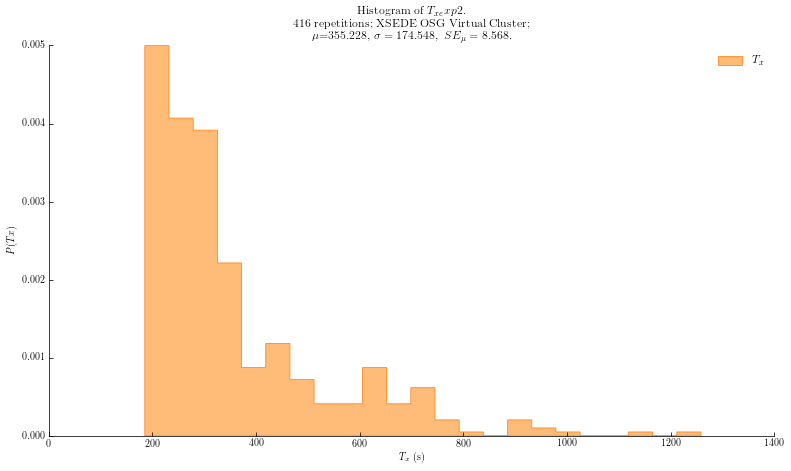

In [28]:
Tx_measures_exp2['skew'] = sps.skew(Txs, bias=True)
Tx_measures_exp2['kurt'] = sps.kurtosis(Txs)

u_skew_test = sps.skewtest(Txs)
u_kurt_test = sps.kurtosistest(Txs)

print Tx_measures_exp2['skew']
print Tx_measures_exp2['kurt']

print u_skew_test
print u_kurt_test

metric      = 'T_x_exp2'
description = 'Histogram of $%s$' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp2)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], Tx_measures_exp2['std'], Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, patches = ax.hist(Txs_exp2, bins='fd',
        normed=1,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[2], 
        color=tableau20[3])

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.set_xlim(150, 700)
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('figures/osg_exp2_cu_spread_hist.pdf', dpi=600, bbox_inches='tight')

In [29]:
# - Fit to the normal distribution: fit the empirical 
#   distribution to the normal for comparison purposes.    
(f_mu, f_sigma) = sps.norm.fit(Txs)
(f_mu_exp1, f_sigma_exp1) = sps.norm.fit(Txs_exp1)
(f_mu_exp2, f_sigma_exp2) = sps.norm.fit(Txs_exp2)

# sample_pdf = np.linspace(min(Txs),max(Txs), len(Txs))
sample_pdf = np.linspace(0,max(Txs), len(Txs))
sample_pdf_exp1 = np.linspace(0,max(Txs_exp1), len(Txs_exp1))
sample_pdf_exp2 = np.linspace(0,max(Txs_exp2), len(Txs_exp2))

1.58898566891e-12
0.00285253077246


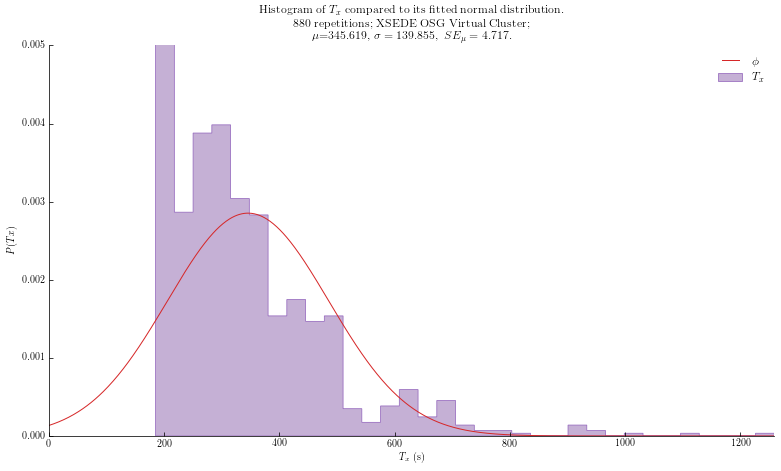

In [30]:
metric      = 'T_x'
description = 'Histogram of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs, bins='fd',
        normed=True,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9])

pdf = mlab.normpdf(sample_pdf, f_mu, f_sigma)
print min(pdf)
print max(pdf)

ax.plot(sample_pdf, 
        pdf, 
        label="$\phi$", 
        color=tableau20[6])

# ax.fill_between(bins, 
#         sample_pdf,
#         color=tableau20[1],
#         alpha=0.25)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_xlim(min(sample_pdf), max(sample_pdf))
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_cu_spread_pdf.pdf', dpi=600, bbox_inches='tight')

1.11292538533e-05
0.00406679109866


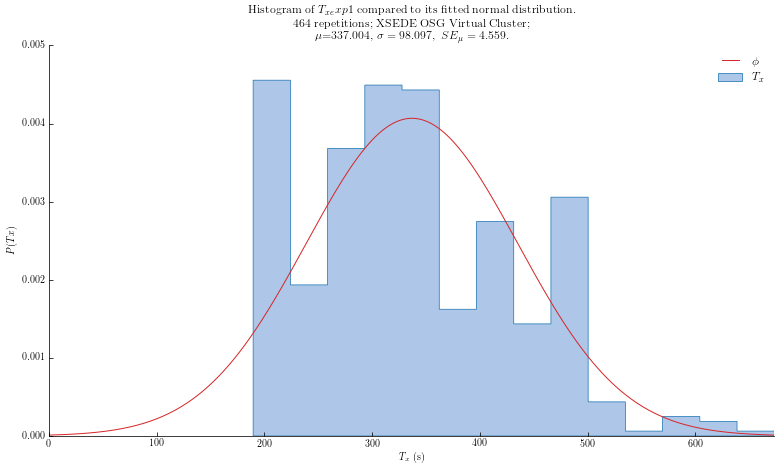

In [31]:
metric      = 'T_x_exp1'
description = 'Histogram of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp1)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], 
                                                           Tx_measures_exp1['std'], 
                                                           Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp1, bins='fd',
        normed=True,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[0], 
        color=tableau20[1])

pdf_exp1 = mlab.normpdf(sample_pdf_exp1, f_mu_exp1, f_sigma_exp1)
print min(pdf_exp1)
print max(pdf_exp1)

ax.plot(sample_pdf_exp1, 
        pdf_exp1, 
        label="$\phi$", 
        color=tableau20[6])

# ax.fill_between(bins, 
#         sample_pdf,
#         color=tableau20[1],
#         alpha=0.25)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_xlim(min(sample_pdf_exp1), max(sample_pdf_exp1))
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_exp1_cu_spread_pdf.pdf', dpi=600, bbox_inches='tight')

3.48659411882e-09
0.00228557055407


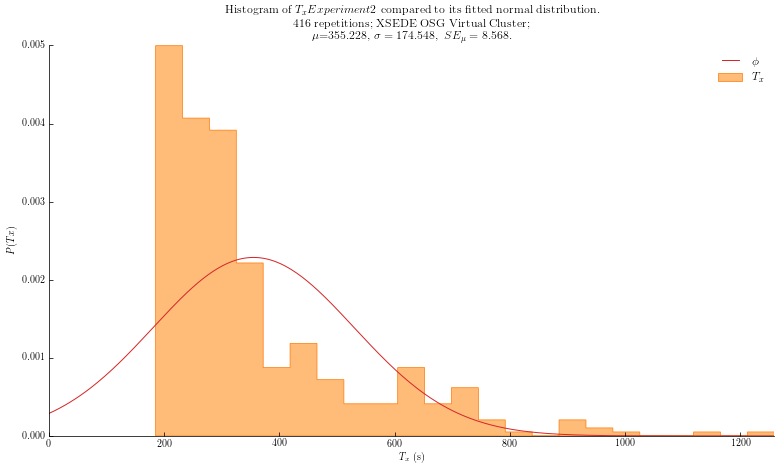

In [32]:
metric      = 'T_x Experiment 2'
description = 'Histogram of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp2)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], 
                                                           Tx_measures_exp2['std'], 
                                                           Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp2, bins='fd',
        normed=True,
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[2], 
        color=tableau20[3])

pdf_exp2 = mlab.normpdf(sample_pdf_exp2, f_mu_exp2, f_sigma_exp2)
print min(pdf_exp2)
print max(pdf_exp2)

ax.plot(sample_pdf_exp2, 
        pdf_exp2, 
        label="$\phi$", 
        color=tableau20[6])

# ax.fill_between(bins, 
#         sample_pdf,
#         color=tableau20[1],
#         alpha=0.25)

# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.set_xlim(min(sample_pdf_exp2), max(sample_pdf_exp2))
ax.set_ylim(0.0, 0.005)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title)#, y=1.05)
plt.legend(loc='upper right')

plt.savefig('osg_exp2_cu_spread_pdf.pdf', dpi=600, bbox_inches='tight')

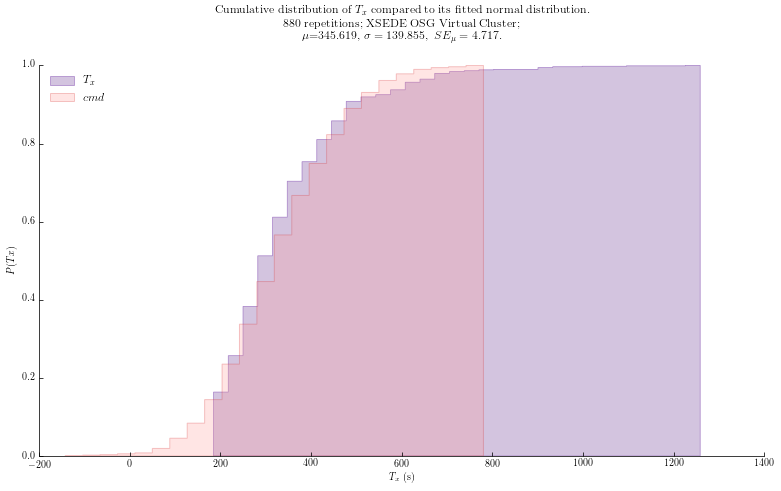

In [33]:
# Values for analytical pdf
sample_pdf = np.random.normal(loc=f_mu, scale=f_sigma, size=len(Txs))

metric      = 'T_x'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

n, bins, p = ax.hist(Txs, 
        bins='fd',
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[8], 
        color=tableau20[9],
        alpha=0.75)

ax.hist(sample_pdf, 
        bins='fd', 
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$cmd$",
        edgecolor=tableau20[6], 
        color=tableau20[7], 
        alpha=0.25)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_cu_cumulative_hist.pdf', dpi=600, bbox_inches='tight')

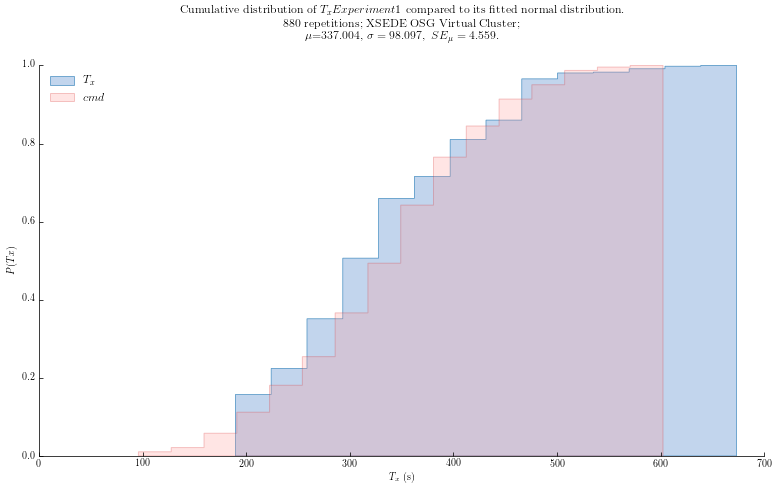

In [34]:
# Values for analytical pdf
sample_pdf_exp1 = np.random.normal(loc=f_mu_exp1, scale=f_sigma_exp1, size=len(Txs_exp1))

metric      = 'T_x Experiment 1'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], 
                                                           Tx_measures_exp1['std'], 
                                                           Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp1, 
        bins='fd',
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[0], 
        color=tableau20[1],
        alpha=0.75)

ax.hist(sample_pdf_exp1, 
        bins='fd', 
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$cmd$",
        edgecolor=tableau20[6], 
        color=tableau20[7], 
        alpha=0.25)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp1_cu_cumulative_hist.pdf', dpi=600, bbox_inches='tight')

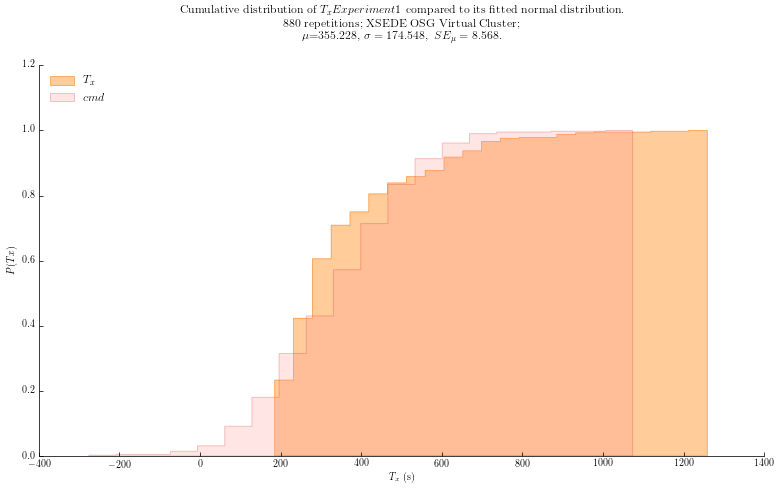

In [35]:
# Values for analytical pdf
sample_pdf_exp2 = np.random.normal(loc=f_mu_exp2, scale=f_sigma_exp2, size=len(Txs_exp2))

metric      = 'T_x Experiment 1'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], 
                                                           Tx_measures_exp2['std'], 
                                                           Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

ax = fig_setup()

n, bins, p = ax.hist(Txs_exp2, 
        bins='fd',
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$T_x$", 
        linewidth=0.75,
        edgecolor=tableau20[2], 
        color=tableau20[3],
        alpha=0.75)

ax.hist(sample_pdf_exp2, 
        bins='fd', 
        normed=True,
        cumulative=True, 
        histtype='stepfilled', 
        label="$cmd$",
        edgecolor=tableau20[6], 
        color=tableau20[7], 
        alpha=0.25)

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp2_cu_cumulative_hist.pdf', dpi=600, bbox_inches='tight')

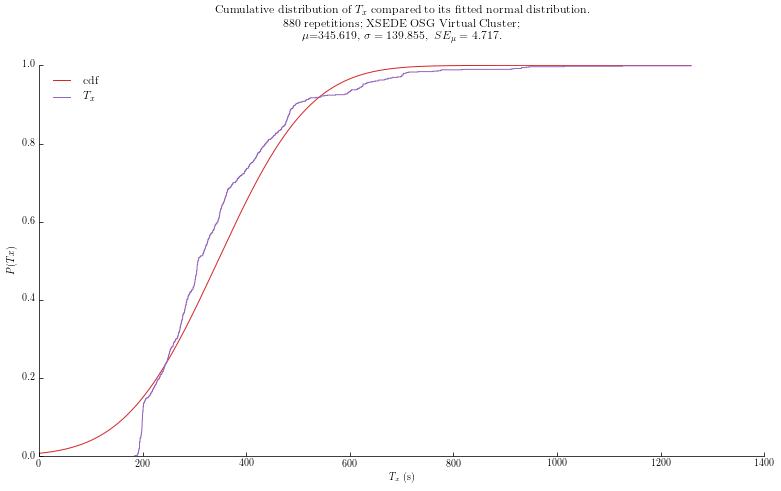

In [36]:
Txs_np = np.array(Txs)

# Cumulative samples
Txs_sum = np.cumsum(np.ones(Txs_np.shape))/len(Txs)

# Values for analytical cdf
sample_cdf = np.linspace(0,max(Txs), len(Txs))

metric      = 'T_x'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures['mu'], Tx_measures['std'], Tx_measures['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

ax.plot(sample_cdf, 
        sps.norm.cdf(sample_cdf, f_mu, f_sigma), 
        label="cdf",
        color=tableau20[6])

ax.step(Txs, 
        Txs_sum,
        label="$T_x$",
        where='post',
        color=tableau20[8])

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_cu_cumulative_plot.pdf', dpi=600, bbox_inches='tight')

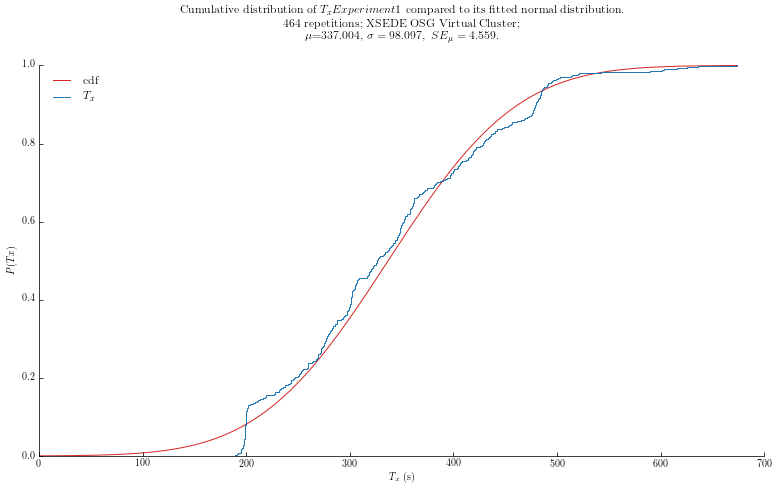

In [37]:
Txs_np_exp1 = np.array(Txs_exp1)

# Cumulative samples
Txs_sum_exp1 = np.cumsum(np.ones(Txs_np_exp1.shape))/len(Txs_exp1)

# Values for analytical cdf
sample_cdf_exp1 = np.linspace(0,max(Txs_exp1), len(Txs_exp1))

metric      = 'T_x Experiment 1'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp1)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp1['mu'], 
                                                           Tx_measures_exp1['std'], 
                                                           Tx_measures_exp1['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

ax.plot(sample_cdf_exp1, 
        sps.norm.cdf(sample_cdf_exp1, f_mu_exp1, f_sigma_exp1), 
        label="cdf",
        color=tableau20[6])

ax.step(Txs_exp1, 
        Txs_sum_exp1,
        label="$T_x$",
        where='post',
        color=tableau20[0])

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp1_cu_cumulative_plot.pdf', dpi=600, bbox_inches='tight')

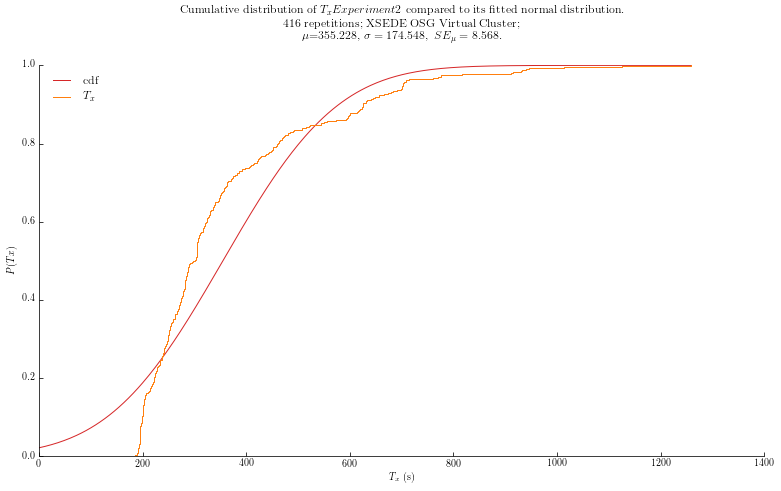

In [38]:
Txs_np_exp2 = np.array(Txs_exp2)

# Cumulative samples
Txs_sum_exp2 = np.cumsum(np.ones(Txs_np_exp2.shape))/len(Txs_exp2)

# Values for analytical cdf
sample_cdf_exp2 = np.linspace(0,max(Txs_exp2), len(Txs_exp2))

metric      = 'T_x Experiment 2'
description = 'Cumulative distribution of $%s$ compared to its fitted normal distribution' % metric
task        = 'Gromacs emulation'
repetition  = '$%s$ repetitions' % len(Txs_exp2)
resource    = 'XSEDE OSG Virtual Cluster'
stats       = '$\mu$=%.3f,\ \sigma=%.3f,\ SE_\mu=%.3f$' % (Tx_measures_exp2['mu'], 
                                                           Tx_measures_exp2['std'], 
                                                           Tx_measures_exp2['sem'])
title       = '%s.\n%s; %s;\n%s.' % (description, repetition, resource, stats)

# fig = plt.figure()
# ax = fig.add_subplot(111)  
# ax.spines["top"].set_visible(False)  
# ax.spines["right"].set_visible(False)  
# ax.get_xaxis().tick_bottom()  
# ax.get_yaxis().tick_left() 

ax = fig_setup()

ax.plot(sample_cdf_exp2, 
        sps.norm.cdf(sample_cdf_exp2, f_mu_exp2, f_sigma_exp2), 
        label="cdf",
        color=tableau20[6])

ax.step(Txs_exp2, 
        Txs_sum_exp2,
        label="$T_x$",
        where='post',
        color=tableau20[2])

plt.ylabel('$P(Tx)$')
plt.xlabel('$T_x$ (s)')
plt.title(title, y=1.05)
plt.legend(loc='upper left')

plt.savefig('osg_exp2_cu_cumulative_plot.pdf', dpi=600, bbox_inches='tight')